In [12]:
import random
from typing import List, Tuple

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
names_text = open("names.txt", "r").read()
words = names_text.splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [14]:
chars = ['.'] + sorted(list(set("".join(words)) - set(['.'])))
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}
VOCABULARY_SIZE = len(chars)
VOCABULARY_SIZE

27

In [15]:
random.shuffle(words)
n = len(words)
train_words = words[:int(0.8*n)]
test_words = words[int(0.8*n):int(0.9*n)]
dev_words = words[int(0.9*n):]

In [39]:
CONTEXT_LENGTH = 3

def build_dataset(words: List[str], context_length: int = 3):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * context_length
        for c in word:
            idx = ctoi[c]
            X.append(context)
            Y.append(idx)
            # print("".join(itoc[i] for i in context), "----->", itoc[idx])
            context = context[1:] + [idx]

    return torch.tensor(X), torch.tensor(Y)

X_train, y_train = build_dataset(train_words, context_length=CONTEXT_LENGTH)
X_test, y_test = build_dataset(test_words, context_length=CONTEXT_LENGTH)
X_dev, y_dev = build_dataset(dev_words, context_length=CONTEXT_LENGTH)

In [ ]:
EMBEDDING_DIMS = 2
HIDDEN_LAYER = 100

class MLP():
    def __init__(self):
        self.C = torch.rand((VOCABULARY_SIZE, EMBEDDING_DIMS), requires_grad=True)

        self.W1 = torch.rand((EMBEDDING_DIMS * CONTEXT_LENGTH, HIDDEN_LAYER), requires_grad=True)
        self.b1 = torch.rand((HIDDEN_LAYER), requires_grad=True)

        self.W2 = torch.rand(HIDDEN_LAYER, VOCABULARY_SIZE, requires_grad=True)
        self.b2 = torch.rand(VOCABULARY_SIZE, requires_grad=True) * 0

        self.loss = None

    def forward(self, X: torch.tensor) -> torch.tensor:
        X = F.tanh(X @ self.W1 + self.b1)
        X = X @ self.W2 + self.b2
        return X

    def calculate_loss(self, X: torch.tensor, Y: torch.tensor) -> torch.tensor:
        self.loss = F.cross_entropy(X, Y)
        return self.loss

    def backward(self):
        self.W1.grad = None
        self.b1.grad = None
        self.W2.grad = None
        self.b2.grad = None
        self.C.grad = None
        self.loss.backward()

    def update(self, lr: float):
        self.W1.data -= self.W1.grad * lr 
        self.b1.data -= self.b1.grad * lr
        self.W2.data -= self.W2.grad * lr
        self.b2.data -= self.b2.grad * lr
        self.C.data -= self.C.grad * lr

    def train(self, X: torch.tensor, Y: torch.tensor, epochs: int, lr: float, batch_size: int):
        for epoch in range(epochs):
            # select mini-batch
            batch_idx = torch.randint(0, len(X), (batch_size,))
            X_train = X[batch_idx]
            y_train = Y[batch_idx]

            embedded = self.embedd(X_train)
            logits = self.forward(embedded)
            self.calculate_loss(logits, y_train)
            self.backward()
            self.update(lr)
            # print(f"{epoch=}, loss={self.loss.item()}")

    def embedd(self, X: torch.tensor) -> torch.tensor:
        X = self.C[X]
        return X.view(-1, EMBEDDING_DIMS * CONTEXT_LENGTH)

    def predict(self, text: str) -> str:
        context = torch.tensor([ctoi[c] for c in text[:CONTEXT_LENGTH]])
        embedd = self.embedd(context)
        logits = self.forward(embedd)
        # select stochasticaly
        idx = torch.multinomial(F.softmax(logits, dim=1), 1).item()
        return text + itoc[idx]
    
    def evaluate(self, X: torch.tensor, Y: torch.tensor) -> float:
        embedded = self.embedd(X)
        logits = self.forward(embedded)
        return F.cross_entropy(logits, Y).item()

In [50]:
# Find loss of an untrained model
mlp = MLP()
mlp.evaluate(X_test, y_test)

5.080120086669922

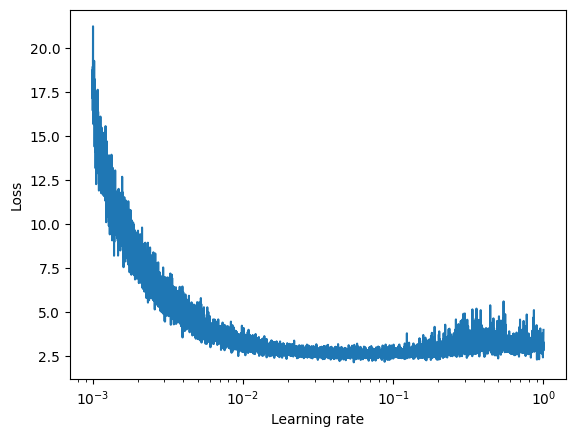

In [33]:
# Let's find the best learning rate
mlp = MLP()

lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre
losses = []

for lr in lrs:
    mlp.train(X_dev, y_dev, epochs=1, lr=lr, batch_size=64)
    loss = mlp.loss.item()
    losses.append(loss)

plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [34]:
# Let's train the model to find best hyperparameters
mlp = MLP()
mlp.train(X_dev, y_dev, epochs=50000, lr=0.1, batch_size=32)

In [37]:
print("Loss on dev-set:", mlp.evaluate(X_dev, y_dev))
print("Loss on test-set:", mlp.evaluate(X_test, y_test))

Loss on dev-set: 2.3741848468780518
Loss on test-set: 2.439335346221924


In [ ]:
# Let's finally train the model on the train dataset
mlp = MLP()
mlp.train(X_train, y_train, epochs=50000, lr=0.1, batch_size=32)

In [ ]:
print("Loss on test-set:", mlp.evaluate(X_test, y_test))